<a href="https://colab.research.google.com/github/marinavillatoro/Reconocimiento-Emociones/blob/main/ReconocimientoDise%C3%B1o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC #SVC es como se llama a svm en la libreria
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve

import seaborn as sns
from collections import Counter


In [2]:
# Conectamos el cuaderno actual con Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Path
Original = '/content/drive/MyDrive/TFG/Original/'

# Cargar audios


In [4]:
OriginalAudios = os.listdir(Original)

file_emotion = [] #Almacena emocion
file_path = []    #Almacena ruta del archivo de audio

for file in OriginalAudios:
    file_path.append(Original + file)  #Para cada file, crea ruta con rutaCarpeta+NombreArchivoAudio

    part=file.split('_')  #Divide nombre archivo
    if part[2][0] == 'A':
      file_emotion.append('asco')
    elif part[2][0] == 'I':
      file_emotion.append('ira')
    elif part[2][0] == 'M':
      file_emotion.append('miedo')
    elif part[2][0] == 'F':
      file_emotion.append('felicidad')
    elif part[2][0] == 'T':
      file_emotion.append('tristeza')
    elif part[2][0] == 'S':
      file_emotion.append('sorpresa')
    else:
      file_emotion.append('Unknown')


emotion = pd.DataFrame(file_emotion, columns=['Emotions'])


path = pd.DataFrame(file_path, columns=['Path'])
Audios_df = pd.concat([emotion, path], axis=1)
Audios_df

,Emotions,Path
0,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T07_...
1,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T02_...
2,tristeza,/content/drive/MyDrive/TFG/Original/U05_M_T05_...
3,tristeza,/content/drive/MyDrive/TFG/Original/U05_M_T04_...
4,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T04_...
...,...,...
1340,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T03_...
1341,tristeza,/content/drive/MyDrive/TFG/Original/U05_M_T04_...
1342,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T03_...
1343,tristeza,/content/drive/MyDrive/TFG/Original/U06_M_T04_...


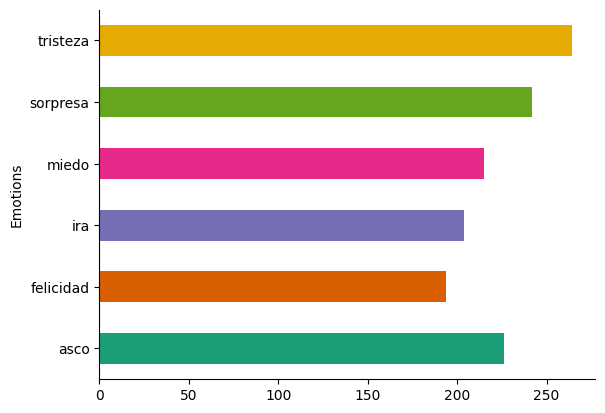

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
Audios_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Extracción carasterísticas

In [6]:
def WinStep(fs,data):
  stWin_seg = 0.02
  st_mframe = stWin_seg * fs
  stWin = st_mframe
  stStep = st_mframe

  mtWin_seg = 1
  mt_mframe = mtWin_seg * fs
  mtWin = mt_mframe
  mtStep = 8000

  return stWin, stStep, mtWin, mtStep


In [7]:
def stEnergy(frame):
  if len(frame) == 0: # Manejar el caso en que el array está vacío
    return 0.0
  return np.sum(frame ** 2) / np.float64(len(frame))

In [8]:
def Energy(data, fs, stWin):

  num_frames = len(data)/ stWin

  EnergyFeature = []


  hamming_window = np.hamming(int(stWin))

  for i in np.arange(int(num_frames)):
    inicio_frame = int(i*stWin)
    fin_frame = int((i+1)*stWin)

    x = data[inicio_frame:fin_frame] * hamming_window
    EnergyFeature.append(stEnergy(x))


  resto_muestras = data[(int(num_frames) * int(stWin)):len(data)]

  if len(resto_muestras)>=0:
    num_ceros = int(stWin) - len(resto_muestras)
    frame_113 = np.concatenate((resto_muestras, np.zeros(num_ceros).astype(int)), axis=None)
    x = data[(int(num_frames) * int(stWin)):len(data)]
    EnergyFeature.append(stEnergy(x))


  return EnergyFeature

In [9]:
def stFeatureExtraction(data, fs, stWin, stStep):
  # Extracción características Short-term

  n_mfcc = 12
  totalNumOfFeatures = 1+1+n_mfcc


  num_frame = int( len(data) / stWin) +1
  features = np.zeros((totalNumOfFeatures, num_frame))

  features[0] = Energy(data, fs, stWin)
  features[1] = librosa.feature.zero_crossing_rate(y = data, frame_length = int(stWin), hop_length = int(stWin))
  features[2:2+n_mfcc] = librosa.feature.mfcc(y= data,n_mfcc=n_mfcc, sr=fs,n_fft=512, hop_length= int(stWin),n_mels=30, window='hamm')

  return features



In [10]:
def  mtFeatureExtraction(data, fs, stWin, stStep, mtWin, mtStep):
  # Calculo promedio y desviación estandar --> Mid-term

  mtWinRatio = int(round(mtWin / stStep))
  mtStepRatio = int(round(mtStep / stStep))

  stFeatures = stFeatureExtraction(data, fs, stWin, stStep)

  numOfFeatures = len(stFeatures)
  numOfStatistics = 2
  mtFeatures = []

  for i in range(numOfStatistics * numOfFeatures):
      mtFeatures.append([])


  for i in range(numOfFeatures):
      curPos = 0
      N = len(stFeatures[i])

      while (curPos < N):
          N1 = curPos
          N2 = curPos + mtWinRatio
          if N2 > N:
              N2 = N
          curStFeatures = stFeatures[i][N1:N2]


          mtFeatures[i].append(np.mean(curStFeatures)) #Extrae la media
          mtFeatures[i+numOfFeatures].append(np.std(curStFeatures)) #Estrae la desviacion tipica

          curPos += mtStepRatio

  return np.array(mtFeatures), stFeatures

In [11]:
def FeatureExtraction(AudiosDataFrame):

  allFeatures = np.array([])
  alldata = []
  stFea = []

  for path, emotions in zip(AudiosDataFrame.Path, AudiosDataFrame.Emotions):

    data, fs = librosa.load(path, sr=None)
    alldata.append(data)
    stWin, stStep, mtWin, mtStep = WinStep(fs,data)


    mtFeatures, stFeatures_post = mtFeatureExtraction(data, fs,stWin, stStep, mtWin, mtStep)
    stFea.append(stFeatures_post)

    LongTermFeatures = np.transpose(mtFeatures)
    LongTermFeatures = LongTermFeatures.mean(axis=0)


    if len(allFeatures) == 0:
      allFeatures = LongTermFeatures

    else:
      allFeatures = np.vstack((allFeatures, LongTermFeatures))

  return allFeatures



In [12]:
allFeatures = FeatureExtraction(Audios_df)

# 1. Separar datos (hold-out)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(allFeatures,emotion, test_size=0.30, shuffle=True, random_state=0)

# 2. Preprocesamiento --> normalización


In [14]:
scaler_train = StandardScaler()
scaler_train.fit(X_train)

StandardScaler()

In [15]:
scaler_test = StandardScaler()
scaler_test.fit(X_test)

StandardScaler()

In [16]:
x_train_scaled = scaler_train.transform(X_train)
x_test_scaled_contest= scaler_test.transform(X_test)
x_test_scaled = scaler_train.transform(X_test)

Normalizacion con minmax

In [17]:
# mmscaler_train = MinMaxScaler()
# mmscaler_train.fit(X_train)

In [18]:
# mmscaler_test = MinMaxScaler()
# mmscaler_test.fit(X_test)

In [19]:
# x_train_scaled = mmscaler_train.transform(X_train)
# x_test_scaled_contest= mmscaler_test.transform(X_test)
# x_test_scaled = mmscaler_train.transform(X_test)

# 3. Entrenamiento (datos train)
# 4. Test (datos test)



## SVM


In [32]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [33]:
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale',decision_function_shape='ovr', break_ties=True, probability=True, random_state=0),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold, #hold-out =10
        verbose    = 0,
        return_train_score = True
      )


In [34]:
y_train_flat = np.ravel(y_train)

In [35]:
_ = grid.fit(X = x_train_scaled, y = y_train_flat)
  # ajusta modelo svm usando validación cruzada

resultados = pd.DataFrame(grid.cv_results_)
  #  crea Dataframe con los resultados con cada hiperparametro C

resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)
  # Filtra resultados para mostrar solo los que nos interesan

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
9,4.83293,0.941601,0.028854,0.999882,0.000354
10,20.691381,0.941590,0.025140,1.000000,0.000000
11,88.586679,0.941590,0.025140,1.000000,0.000000
18,2335721.46909,0.941590,0.025140,1.000000,0.000000
17,545559.478117,0.941590,0.025140,1.000000,0.000000
16,127427.49857,0.941590,0.025140,1.000000,0.000000
15,29763.514416,0.941590,0.025140,1.000000,0.000000
14,6951.927962,0.941590,0.025140,1.000000,0.000000
13,1623.776739,0.941590,0.025140,1.000000,0.000000
12,379.269019,0.941590,0.025140,1.000000,0.000000


In [36]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.832930238571752} : 0.9416013437849943 accuracy


In [37]:
mapeo_emociones = {0: 'asco', 1: 'felicidad', 2: 'ira', 3: 'miedo', 4: 'sorpresa', 5: 'tristeza'}
y_test_flat = np.ravel(y_test)

predicciones_prob = modelo.predict_proba(x_test_scaled_contest) #y_prob
prediccion_emocion = []

for i in range(len(x_test_scaled_contest)):
  probabilidades_predichas = predicciones_prob[i]
  emocion_prediccion = np.argmax(probabilidades_predichas)
  prediccion_emocion.append(mapeo_emociones[emocion_prediccion])


prediccion_emocion = np.array(prediccion_emocion)


In [38]:
# Accuracy
# ==============================================================================
accuracy_prob = accuracy_score(y_test,prediccion_emocion)
print("")
print(f"El accuracy de test es: {100*accuracy_prob}%")


El accuracy de test es: 96.03960396039604%


In [39]:
# Matriz de confusión
# ==============================================================================
cm_prob = pd.crosstab(
    np.ravel(y_test), #np.ravel(emotion)
    prediccion_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)
cm_prob

Predicción,asco,felicidad,ira,miedo,sorpresa,tristeza
Real,,,,,,
asco,73,1,0,1,0,0
felicidad,0,54,0,0,1,0
ira,0,1,53,0,1,0
miedo,1,1,0,60,1,2
sorpresa,0,4,1,0,72,0
tristeza,0,1,0,0,0,76


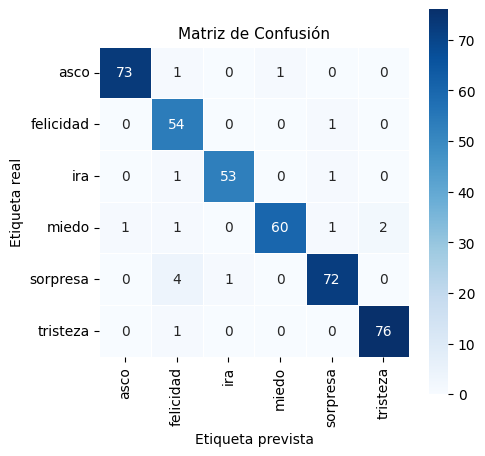

In [40]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_prob, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [41]:
mc_p = confusion_matrix(y_test, prediccion_emocion)
accuracy_per_class = mc_p.diagonal() / mc_p.sum(axis=1)
for i, acc in enumerate(accuracy_per_class):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 97.33%
Precisión para la clase felicidad: 98.18%
Precisión para la clase ira: 96.36%
Precisión para la clase miedo: 92.31%
Precisión para la clase sorpresa: 93.51%
Precisión para la clase tristeza: 98.70%


In [42]:
# Informe de clasificación
informe_clasificacion = classification_report(y_test, prediccion_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.99      0.97      0.98        75
   felicidad       0.87      0.98      0.92        55
         ira       0.98      0.96      0.97        55
       miedo       0.98      0.92      0.95        65
    sorpresa       0.96      0.94      0.95        77
    tristeza       0.97      0.99      0.98        77

    accuracy                           0.96       404
   macro avg       0.96      0.96      0.96       404
weighted avg       0.96      0.96      0.96       404



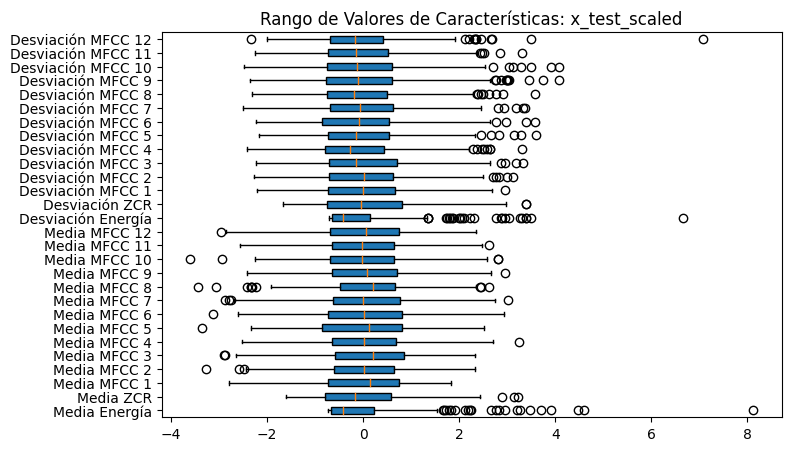

In [43]:
num_features = len(x_test_scaled[0])
feature_names = ["Media Energía", "Media ZCR", "Media MFCC 1", "Media MFCC 2", "Media MFCC 3", "Media MFCC 4", "Media MFCC 5", "Media MFCC 6","Media MFCC 7",
"Media MFCC 8","Media MFCC 9","Media MFCC 10","Media MFCC 11","Media MFCC 12", "Desviación Energía", "Desviación ZCR", "Desviación MFCC 1", "Desviación MFCC 2", "Desviación MFCC 3",
"Desviación MFCC 4","Desviación MFCC 5","Desviación MFCC 6","Desviación MFCC 7","Desviación MFCC 8","Desviación MFCC 9","Desviación MFCC 10","Desviación MFCC 11","Desviación MFCC 12"]
plt.figure(figsize=(8, 5))


plt.boxplot(x_test_scaled, vert=False, patch_artist=True)

plt.yticks(range(1, num_features + 1), feature_names)
plt.title('Rango de Valores de Características: x_test_scaled')
plt.show()

## GB


In [44]:
param_grid_GB = {
    'max_iter'      : [50, 100, 500, 1000],
    'max_depth'     : [3, 5, 10, 20],
    'learning_rate' : [0.001, 0.01, 0.1]
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_GB = GridSearchCV(
        estimator  = HistGradientBoostingClassifier(random_state=0),
        param_grid = param_grid_GB,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GB.fit(X = x_train_scaled, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=HistGradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 10, 20],
                         'max_iter': [50, 100, 500, 1000]},
             return_train_score=True, scoring='accuracy')

In [45]:
resultado_GB = pd.DataFrame(grid_GB.cv_results_)
resultado_GB.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_max_iter,mean_test_score,std_test_score,mean_train_score,std_train_score
46,0.1,20,500,0.878903,0.038486,1.0,0.0
43,0.1,10,1000,0.878891,0.034845,1.0,0.0
38,0.1,5,500,0.877872,0.032186,1.0,0.0
39,0.1,5,1000,0.876809,0.031822,1.0,0.0


In [46]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (GB) (cv)")
print("----------------------------------------")
print(grid_GB.best_params_, ":", grid_GB.best_score_, grid_GB.scoring)

modelo_GB = grid_GB.best_estimator_
predicciones_GB = modelo_GB.predict(x_test_scaled)


----------------------------------------
Mejores hiperparámetros encontrados (GB) (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 20, 'max_iter': 500} : 0.8789025755879057 accuracy


In [47]:
prediccionesGB_prob = modelo_GB.predict_proba(x_test_scaled_contest) #y_prob
prediccionGB_emocion = []

for i in range(len(X_test)):
  probabilidades_predichas = prediccionesGB_prob[i]
  emocionGB_prediccion = np.argmax(probabilidades_predichas)
  prediccionGB_emocion.append(mapeo_emociones[emocionGB_prediccion])

prediccionGB_emocion = np.array(prediccionGB_emocion)

In [48]:
# Accuracy
# ==============================================================================
accuracy_GB = accuracy_score(y_test_flat,prediccionGB_emocion)
print("")
print(f"GB: El accuracy de test es: {100*accuracy_GB}%")


GB: El accuracy de test es: 89.35643564356435%


In [49]:
# Matriz de confusión
# ==============================================================================
cmGB_prob = pd.crosstab(
    np.ravel(y_test),
    prediccionGB_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)

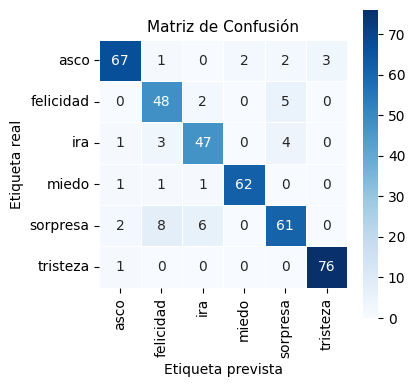

In [50]:
plt.figure(figsize=(4,4))
sns.heatmap(cmGB_prob, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [51]:
mcGB = confusion_matrix(y_test, prediccionGB_emocion)
accuracy_per_classGB = mcGB.diagonal() / mcGB.sum(axis=1)
for i, acc in enumerate(accuracy_per_classGB):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 89.33%
Precisión para la clase felicidad: 87.27%
Precisión para la clase ira: 85.45%
Precisión para la clase miedo: 95.38%
Precisión para la clase sorpresa: 79.22%
Precisión para la clase tristeza: 98.70%


In [52]:
# Informe de clasificación
# ==============================================================================
informe_clasificacion_GB = classification_report(y_test, prediccionGB_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion_GB)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.93      0.89      0.91        75
   felicidad       0.79      0.87      0.83        55
         ira       0.84      0.85      0.85        55
       miedo       0.97      0.95      0.96        65
    sorpresa       0.85      0.79      0.82        77
    tristeza       0.96      0.99      0.97        77

    accuracy                           0.89       404
   macro avg       0.89      0.89      0.89       404
weighted avg       0.89      0.89      0.89       404



## RF

In [53]:
param_grid_RF = {
    'n_estimators': [100, 150,200],
    'max_features':["auto", "sqrt", "log2", 0.5, 0.7, 1.0],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_RF = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 0),
        param_grid = param_grid_RF,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_RF.fit(X = x_train_scaled, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7,
                                          1.0],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='accuracy')

In [54]:
resultados_RF = pd.DataFrame(grid_RF.cv_results_)
resultados_RF.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
56,gini,20,auto,200,0.886349,0.02339,1.0,0.0
59,gini,20,sqrt,200,0.886349,0.02339,1.0,0.0
2,gini,None,auto,200,0.885286,0.02423,1.0,0.0
5,gini,None,sqrt,200,0.885286,0.02423,1.0,0.0


In [55]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (RF) (cv)")
print("----------------------------------------")
print(grid_RF.best_params_, ":", grid_RF.best_score_, grid_RF.scoring)

modelo_RF = grid_RF.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (RF) (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200} : 0.8863493840985444 accuracy


In [56]:
prediccionesRF_prob = modelo_RF.predict_proba(x_test_scaled_contest) #y_prob
prediccionRF_emocion = []

for i in range(len(X_test)):
  probabilidades_predichasRF = prediccionesRF_prob[i]
  emocionRF_prediccion = np.argmax(probabilidades_predichasRF)
  prediccionRF_emocion.append(mapeo_emociones[emocionRF_prediccion])


prediccionRF_emocion = np.array(prediccionRF_emocion)

In [57]:
# Accuracy
# ==============================================================================
accuracy_RF = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccionRF_emocion,
            normalize = True
           )
print("")
print(f"RF: El accuracy de test es: {100*accuracy_RF}%")


RF: El accuracy de test es: 87.62376237623762%


In [58]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_RF = pd.crosstab(
    np.ravel(y_test),
    prediccionRF_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix_RF

Predicción,asco,felicidad,ira,miedo,sorpresa,tristeza
Real,,,,,,
asco,62,1,0,2,5,5
felicidad,0,51,1,0,3,0
ira,1,2,49,0,3,0
miedo,2,2,0,59,1,1
sorpresa,2,10,0,1,64,0
tristeza,2,0,0,6,0,69


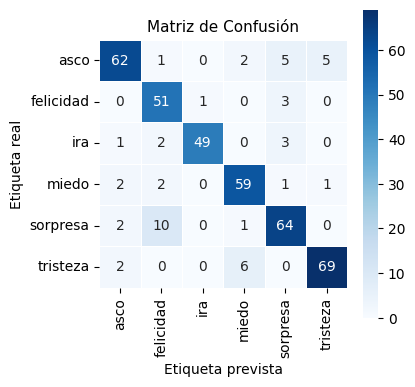

In [59]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_RF, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [60]:
mcRF= confusion_matrix(y_test, prediccionRF_emocion)
accuracy_per_classRF = mcRF.diagonal() / mcRF.sum(axis=1)
for i, acc in enumerate(accuracy_per_classRF):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 82.67%
Precisión para la clase felicidad: 92.73%
Precisión para la clase ira: 89.09%
Precisión para la clase miedo: 90.77%
Precisión para la clase sorpresa: 83.12%
Precisión para la clase tristeza: 89.61%


In [61]:
# Informe de clasificación
# ==============================================================================
informe_clasificacion_RF = classification_report(y_test, prediccionRF_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion_RF)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.90      0.83      0.86        75
   felicidad       0.77      0.93      0.84        55
         ira       0.98      0.89      0.93        55
       miedo       0.87      0.91      0.89        65
    sorpresa       0.84      0.83      0.84        77
    tristeza       0.92      0.90      0.91        77

    accuracy                           0.88       404
   macro avg       0.88      0.88      0.88       404
weighted avg       0.88      0.88      0.88       404



# 5. Creación nueva clase Unknown
Se va a crear una nueva clase unknown.

Se va a clasificar con unknown, aquellas muestras cuya propabilidad de la clase predicha no supere ciertos umbrales.

## Códigos para la nueva clase

In [83]:
def cdf_Probmax(predicciones_prob, prediccion_emocion, y_test):

  bien_mayores = []
  mal_mayores = []


  indices_errores = np.where(prediccion_emocion != y_test)[0]

  for indice_error in indices_errores:
    probabilidades_predichas = predicciones_prob[indice_error]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_mayor = prob_ordenadas[0]
    mal_mayores.append(probabilidades_predichas[prob_mayor])

  indicesSS_aciertos = np.where(prediccion_emocion == y_test)[0]

  for indice_aciertos in indicesSS_aciertos:
    probabilidades_predichas = predicciones_prob[indice_aciertos]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_mayor = prob_ordenadas[0]
    bien_mayores.append(probabilidades_predichas[prob_mayor])


  prob_bien_ordenadas = np.sort(bien_mayores)
  prob_mal_ordenadas = np.sort(mal_mayores)

  intervalos = np.arange(0, 1.1, 0.1)

    # Calcular la función de distribución acumulada para las muestras bien clasificadas
  cdf_bien = [np.sum(prob_bien_ordenadas <= intervalo) / len(prob_bien_ordenadas) for intervalo in intervalos]

    # Calcular la función de distribución acumulada para las muestras mal clasificadas
  cdf_mal = [np.sum(prob_mal_ordenadas <= intervalo) / len(prob_mal_ordenadas) for intervalo in intervalos]

    # Graficar ambas funciones de distribución acumulada en la misma figura
  plt.plot(intervalos, cdf_bien, label='Bien clasificadas')
  plt.plot(intervalos, cdf_mal, label='Mal clasificadas')
  plt.xlabel('Probabilidad Máxima')
  plt.ylabel('Probabilidad Acumulada')
  plt.title('Función de Distribución Acumulada de las Probabilidades Máximas')
  plt.xlim([0,1])
  plt.legend()
  plt.grid(True)
  plt.show()

In [84]:
def cdf_Probdif(predicciones_prob, prediccion_emocion, y_test_flat):

  bien_dif = []
  mal_dif = []

  indicesSS_aciertos = np.where(prediccion_emocion == y_test_flat)[0]
  for indice_aciertos in indicesSS_aciertos:
    probabilidades_predichas = predicciones_prob[indice_aciertos]
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_primera = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_primera]-probabilidades_predichas[prob_segunda]
    bien_dif.append(diferencia)

  indices_errores = np.where(prediccion_emocion != y_test_flat)[0]
  for indice_error in indices_errores:
    probabilidades_predichas = predicciones_prob[indice_error]
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_primera = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_primera]-probabilidades_predichas[prob_segunda]
    mal_dif.append(diferencia)



  prob_bien_ordenadas = np.sort(bien_dif)
  prob_mal_ordenadas = np.sort(mal_dif)
  intervalos = np.arange(0, 1.1, 0.1)

    # Calcular la función de distribución acumulada para las muestras bien clasificadas
  cdf_bien = [np.sum(prob_bien_ordenadas <= intervalo) / len(prob_bien_ordenadas) for intervalo in intervalos]

    # Calcular la función de distribución acumulada para las muestras mal clasificadas
  cdf_mal = [np.sum(prob_mal_ordenadas <= intervalo) / len(prob_mal_ordenadas) for intervalo in intervalos]

    # Graficar ambas funciones de distribución acumulada en la misma figura
  plt.plot(intervalos, cdf_bien, label='Bien clasificadas')
  plt.plot(intervalos, cdf_mal, label='Mal clasificadas')
  plt.xlabel('Probabilidad Diferencia')
  plt.ylabel('Probabilidad Acumulada')
  plt.title('Función de Distribución Acumulada de las diferencia de probabilidades')
  plt.xlim([0,1])
  plt.legend()
  plt.grid(True)
  plt.show()

In [85]:
def DescartaFueraUmbral(predicciones_prob,predicciones,X_test,Y_test,Thmax, Thdif):

  prediccionesNuevas = []
  X_test_nuevo = []
  Y_test_nuevo = []
  perdidas = 0
  perdidas_malas = 0
  biendentro =0


  for i in range(len(Y_test)):


    probabilidades_predichas = predicciones_prob[i]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

    emocion_real = Y_test[i]
    prob_max = np.max(probabilidades_predichas)

    prob_mayor = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]


    if prob_max>Thmax and diferencia>Thdif:
      prediccionesNuevas.append(predicciones[i])
      X_test_nuevo.append(X_test[i])
      Y_test_nuevo.append(Y_test[i])
      if predicciones[i] == emocion_real:
        biendentro = biendentro +1 #Si funciona


    else:
      if predicciones[i] == emocion_real:
        perdidas = perdidas +1
      else:
        perdidas_malas = perdidas_malas+1


  return np.array(prediccionesNuevas), np.array(X_test_nuevo), np.array(Y_test_nuevo), perdidas, perdidas_malas, biendentro

In [86]:
def ClaseUnknown(predicciones_prob,predicciones,X_test,Y_test, Thmax, Thdif):

  prediccionesNuevas = []
  emocionesNuevas = []
  X_test_nuevo = []
  Y_test_nuevo = []
  perdidas = 0
  perdidas_malas = 0


  for i in range(len(predicciones)):

    probabilidades_predichas = predicciones_prob[i]
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

    emocion_real = Y_test[i]
    prob_max = np.max(probabilidades_predichas)



    prob_mayor = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]


    if prob_max>Thmax and diferencia>Thdif:
      prediccionesNuevas.append(predicciones[i])
      X_test_nuevo.append(X_test[i])
      Y_test_nuevo.append(Y_test[i])

    else:
      prediccionesNuevas.append('unknown')
      X_test_nuevo.append(X_test[i])

      Y_test_nuevo.append(Y_test[i])


      if predicciones[i] == emocion_real:
        perdidas = perdidas +1
      else:
        perdidas_malas = perdidas_malas +1


  return np.array(prediccionesNuevas), np.array(X_test_nuevo), np.array(Y_test_nuevo), perdidas, perdidas_malas

In [87]:
def calcular_accuracy_umbral_Prob(predicciones_prob, predicciones_, X_test, Y_test, Thmax_range):
    accuracies_eliminar = []
    accuracies_unknown = []

    for Thmax in Thmax_range:
        prediccionesNuevas, X_test_nuevo, Y_test_nuevo, perdidas, perdidas_malas,biendentro = DescartaFueraUmbral(predicciones_prob, predicciones_, X_test, Y_test, Thmax, 0.0)


        accuracy_eliminar = biendentro/len(X_test_nuevo)
        accuracy_unknown = biendentro / len(X_test)


        accuracies_eliminar.append(accuracy_eliminar)
        accuracies_unknown.append(accuracy_unknown)

    fig, ax1 = plt.subplots()

    line1, = ax1.plot(Thmax_range, accuracies_eliminar, label='Accuacy dentro umbral', color='red')
    line2, = ax1.plot(Thmax_range, accuracies_unknown, label='Accuracy unknown', color='green')
    ax1.set_xlabel('Umbral de probabilidad máxima (Thmax)')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.tick_params('y', colors='black')
    ax1.set_ylim([0.1, 1])


    fig.tight_layout()


    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower left')

    ax1.grid(True)

    plt.title('Efecto del Umbral Prob max en el Número de Muestras y el Accuracy del Modelo')
    plt.show()


In [88]:
def calcular_accuracy_umbral_Dif(predicciones_prob, predicciones__, X_test, Y_test, Thdif_range):
    accuracies_eliminar = []
    accuracies_unknown = []

    for Thdif in Thdif_range:
        prediccionesNuevas, X_test_nuevo, Y_test_nuevo, perdidas, perdidas_malas, biendentro = DescartaFueraUmbral(predicciones_prob, predicciones__, X_test, Y_test, 0.0, Thdif)


        accuracy_eliminar = biendentro/len(X_test_nuevo)
        accuracy_unknown = biendentro / len(X_test)

        accuracies_eliminar.append(accuracy_eliminar)
        accuracies_unknown.append(accuracy_unknown)

    fig, ax1 = plt.subplots()

    line1, = ax1.plot(Thmax_range, accuracies_eliminar, label='Accuracy dentro umbral', color='red')
    line2, = ax1.plot(Thmax_range, accuracies_unknown, label='Accuracy unknown', color='green')
    ax1.set_xlabel('Umbral de diferencia de probabilidades (Thdif)')
    ax1.set_ylabel('Accuracy', color='black')

    ax1.set_ylim([0.1, 1])
    ax1.tick_params('y', colors='black')

    fig.tight_layout()

    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower left')
    ax1.grid(True)

    plt.title('Efecto del Umbral diferencia en el Número de Muestras y el Accuracy del Modelo')
    plt.show()

## SVM

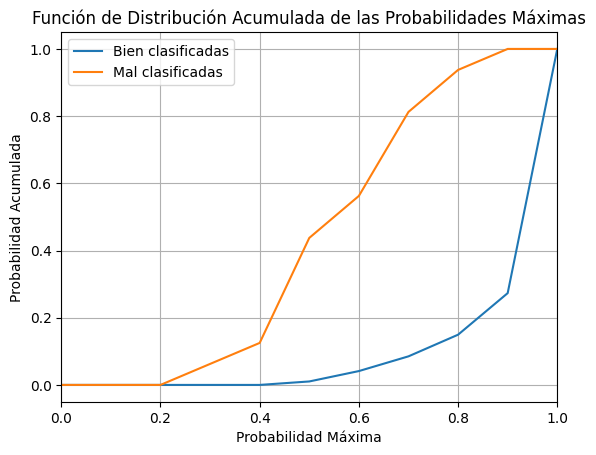

In [89]:
cdf_Probmax(predicciones_prob, prediccion_emocion, y_test_flat)

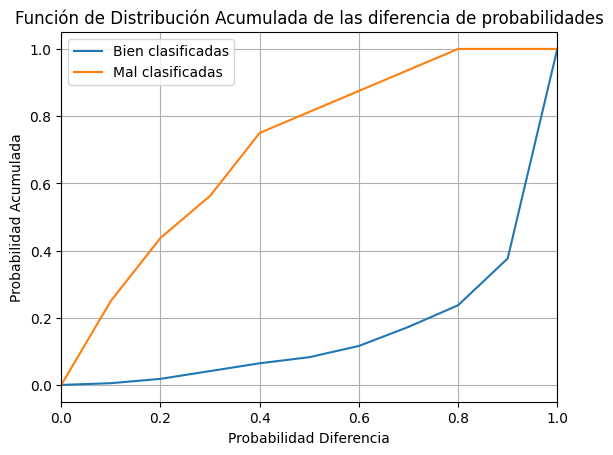

In [90]:
cdf_Probdif(predicciones_prob, prediccion_emocion, y_test_flat)

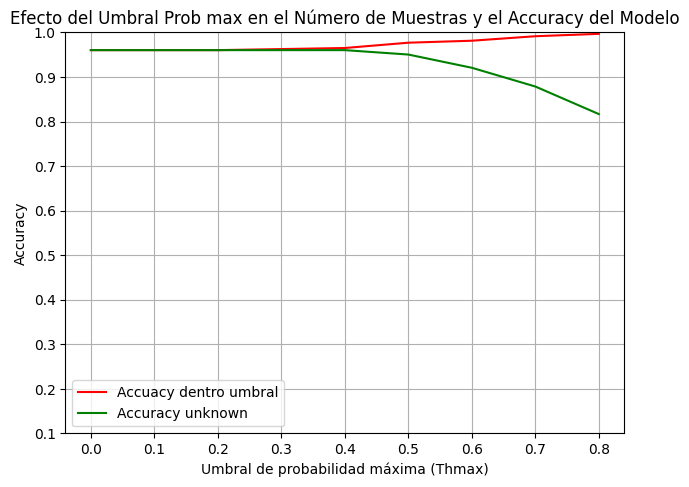

In [91]:
Thmax_range = np.arange(0.0, 0.9, 0.1)
calcular_accuracy_umbral_Prob(predicciones_prob, prediccion_emocion, x_test_scaled, y_test_flat, Thmax_range)

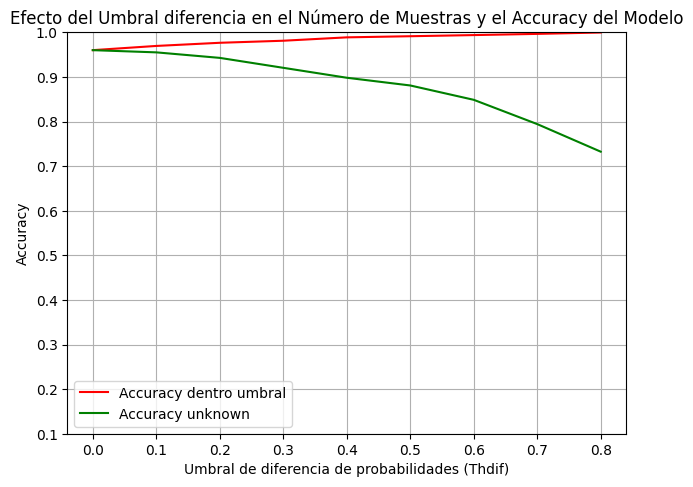

In [92]:
Thdif_range = np.arange(0.0, 0.9, 0.1)
calcular_accuracy_umbral_Dif(predicciones_prob, prediccion_emocion, x_test_scaled, y_test_flat, Thdif_range)

In [93]:
ThMax_ = 0.5
ThDif_ = 0.2
predicciones_ConUn, X_test__ConUn, Y_test_ConUn, perdidas_ConUn, perdidas_malas_ConUn = ClaseUnknown(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat, ThMax_, ThDif_)

predicciones_Ignorando, X_test_Ignorando, Y_test_Ignorando, perdidas_Ignorando, perdidas_malas_Ignorando, biendentro = DescartaFueraUmbral(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat, ThMax_, ThDif_)

In [94]:
accuracy_ConUn = accuracy_score(Y_test_ConUn,predicciones_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_} y Thdif={ThDif_} es: {100*accuracy_ConUn}%, \npero se tienen {perdidas_ConUn} perdidas de datos bien clasificados y {perdidas_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracy_Ignorando = accuracy_score(Y_test_Ignorando,predicciones_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_} y Thdif={ThDif_} es: {100*accuracy_Ignorando}%, \npero se tienen {perdidas_Ignorando} perdidas de datos bien clasificados y {perdidas_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.5 y Thdif=0.2 es: 93.8118811881188%, 
pero se tienen 9 perdidas de datos bien clasificados y 8 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.5 y Thdif=0.2 es: 97.9328165374677%, 
pero se tienen 9 perdidas de datos bien clasificados y 8 perdidas de datos mal clasificados


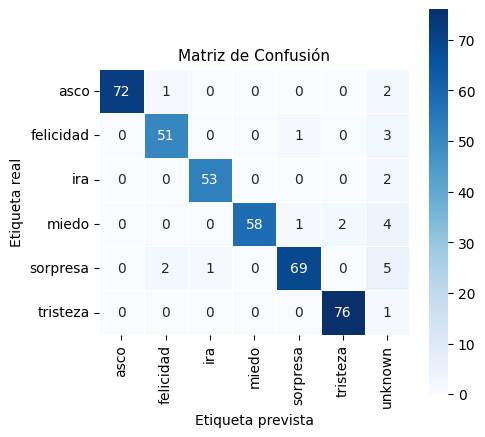

In [95]:
cm_unknown = pd.crosstab(
    Y_test_ConUn, #np.ravel(emotion)
    predicciones_ConUn,
    rownames=['Real'],
    colnames=['Predicción']
)

plt.figure(figsize=(5,5))
sns.heatmap(cm_unknown, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_ConUn)
plt.show()

## GB

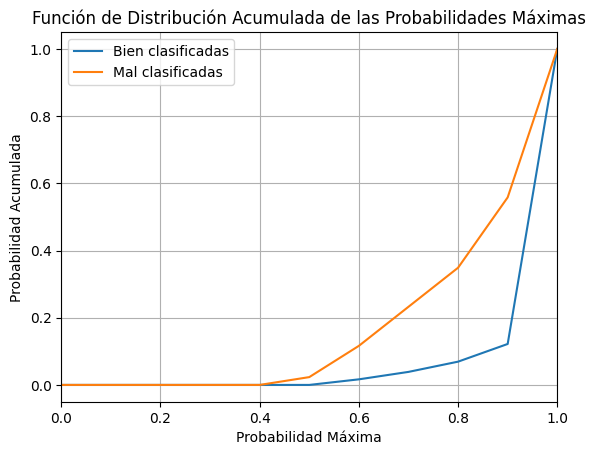

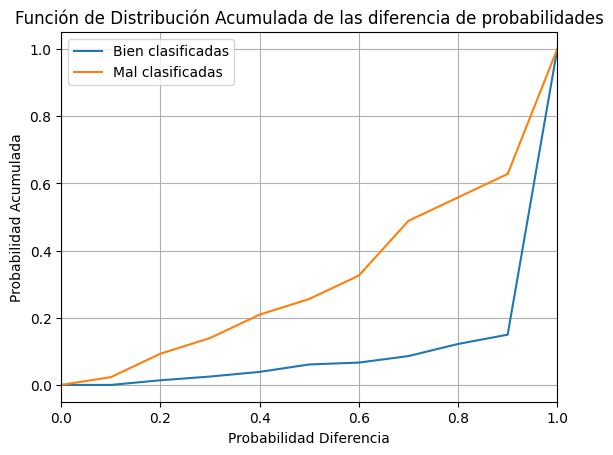

In [96]:
cdf_Probmax(prediccionesGB_prob, prediccionGB_emocion, y_test_flat)
cdf_Probdif(prediccionesGB_prob, prediccionGB_emocion, y_test_flat)

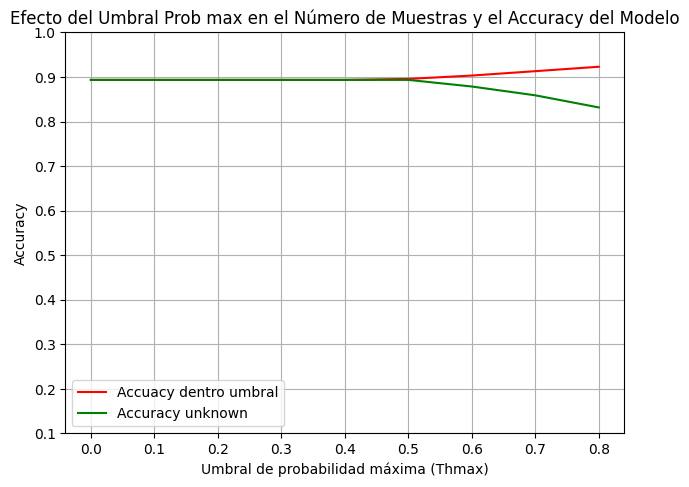

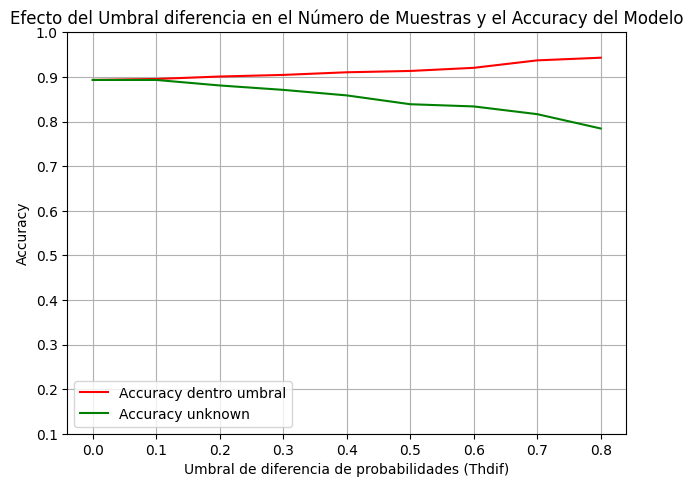

In [97]:
calcular_accuracy_umbral_Prob(prediccionesGB_prob, prediccionGB_emocion, x_test_scaled, y_test_flat, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesGB_prob, prediccionGB_emocion, x_test_scaled, y_test_flat, Thdif_range)

In [98]:
ThMax_GB = 0.5
ThDif_GB = 0.1
prediccionesGB_ConUn, X_testGB_ConUn, Y_testGB_ConUn, perdidasGB_ConUn, perdidasGB_malas_ConUn = ClaseUnknown(prediccionesGB_prob,prediccionGB_emocion, x_test_scaled, y_test_flat, ThMax_GB, ThDif_GB)

prediccionesGB_Ignorando, X_testGB_Ignorando, Y_testGB_Ignorando, perdidasGB_Ignorando, perdidasGB_malas_Ignorando, biendentroGB = DescartaFueraUmbral(prediccionesGB_prob,prediccionGB_emocion, x_test_scaled, y_test_flat, ThMax_GB, ThDif_GB)


In [99]:
accuracyGB_ConUn = accuracy_score(Y_testGB_ConUn,prediccionesGB_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_GB} y Thdif={ThDif_GB} es: {100*accuracyGB_ConUn}%, \npero se tienen {perdidasGB_ConUn} perdidas de datos bien clasificados y {perdidasGB_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyGB_Ignorando = accuracy_score(Y_testGB_Ignorando,prediccionesGB_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_GB} y Thdif={ThDif_GB} es: {100*accuracyGB_Ignorando}%, \npero se tienen {perdidasGB_Ignorando} perdidas de datos bien clasificados y {perdidasGB_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.5 y Thdif=0.1 es: 89.35643564356435%, 
pero se tienen 0 perdidas de datos bien clasificados y 1 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.5 y Thdif=0.1 es: 89.57816377171216%, 
pero se tienen 0 perdidas de datos bien clasificados y 1 perdidas de datos mal clasificados


## RF

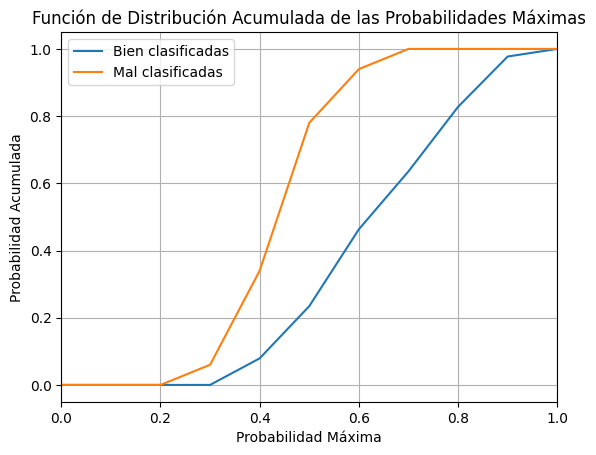

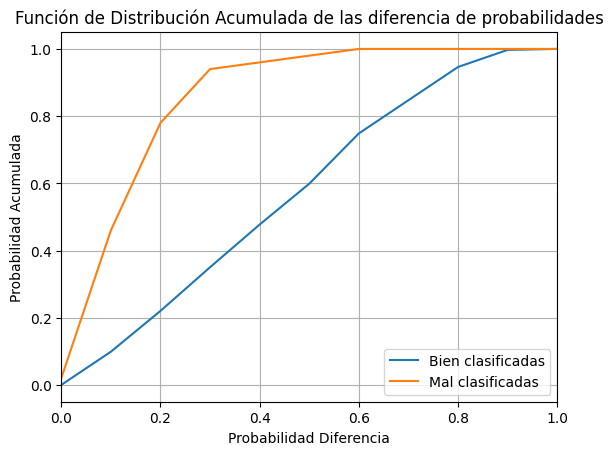

In [100]:
cdf_Probmax(prediccionesRF_prob, prediccionRF_emocion, y_test_flat)
cdf_Probdif(prediccionesRF_prob, prediccionRF_emocion, y_test_flat)

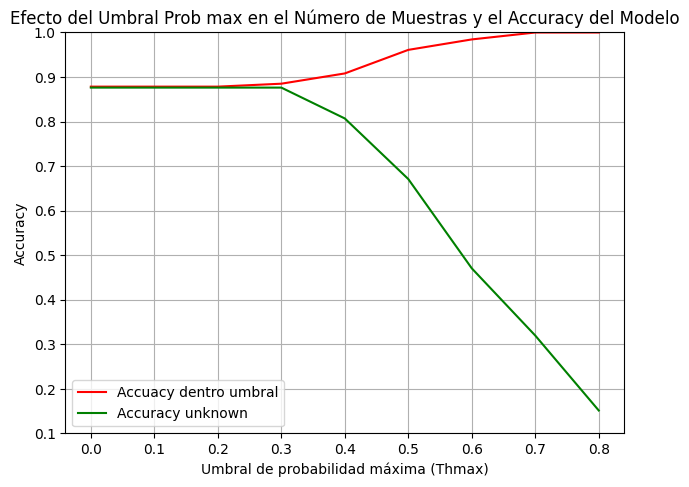

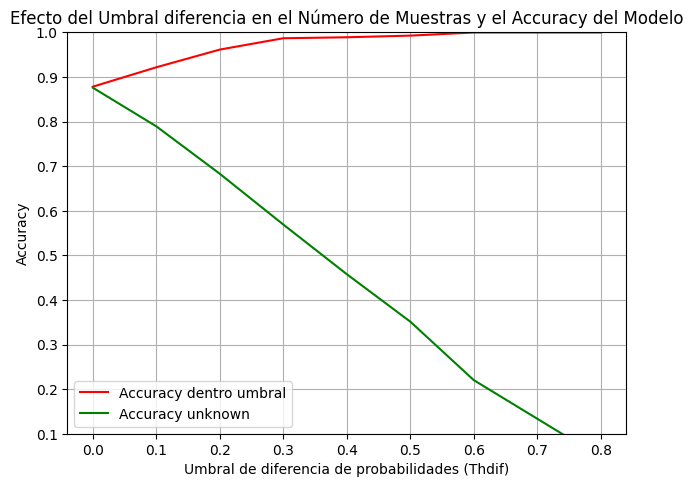

In [101]:
calcular_accuracy_umbral_Prob(prediccionesRF_prob, prediccionRF_emocion, x_test_scaled, y_test_flat, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesRF_prob, prediccionRF_emocion, x_test_scaled, y_test_flat, Thdif_range)

In [102]:
ThMax_RF = 0.0
ThDif_RF = 0.0
prediccionesRF_ConUn, X_testRF_ConUn, Y_testRF_ConUn, perdidasRF_ConUn, perdidasRF_malas_ConUn = ClaseUnknown(prediccionesRF_prob,prediccionRF_emocion, x_test_scaled, y_test_flat, ThMax_RF, ThDif_RF)

prediccionesRF_Ignorando, X_testRF_Ignorando, Y_testRF_Ignorando, perdidasRF_Ignorando, perdidasRF_malas_Ignorando, biendentroRF = DescartaFueraUmbral(prediccionesRF_prob,prediccionRF_emocion, x_test_scaled, y_test_flat, ThMax_RF, ThDif_RF)


In [103]:
accuracyRF_ConUn = accuracy_score(Y_testRF_ConUn,prediccionesRF_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_RF} y Thdif={ThDif_RF} es: {100*accuracyRF_ConUn}%, \npero se tienen {perdidasRF_ConUn} perdidas de datos bien clasificados y {perdidasRF_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyRF_Ignorando = accuracy_score(Y_testRF_Ignorando,prediccionesRF_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_RF} y Thdif={ThDif_RF} es: {100*accuracyRF_Ignorando}%, \npero se tienen {perdidasRF_Ignorando} perdidas de datos bien clasificados y {perdidasRF_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.0 y Thdif=0.0 es: 87.62376237623762%, 
pero se tienen 0 perdidas de datos bien clasificados y 1 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.0 y Thdif=0.0 es: 87.84119106699751%, 
pero se tienen 0 perdidas de datos bien clasificados y 1 perdidas de datos mal clasificados


# Crema-D --> test

In [104]:
Crema = '/content/drive/MyDrive/TFG/AudioWAV/'

In [105]:
CremaAudios = os.listdir(Crema)

file_emotion_Cr = []
file_path_Cr= []


for files in CremaAudios:
    file_path_Cr.append(Crema + files)

    part=files.split('_')
    if part[2] == 'SAD':
      file_emotion_Cr.append('tristeza')
    elif part[2] == 'ANG':
      file_emotion_Cr.append('ira')
    elif part[2] == 'DIS':
      file_emotion_Cr.append('asco')
    elif part[2] == 'FEA':
      file_emotion_Cr.append('miedo')
    elif part[2] == 'HAP':
      file_emotion_Cr.append('felicidad')

    else:
      file_emotion_Cr.append('Unknown')

emotion_Cr = pd.DataFrame(file_emotion_Cr, columns=['Emotions'])

path_Crema = pd.DataFrame(file_path_Cr, columns=['Path'])
Crema_df = pd.concat([emotion_Cr, path_Crema], axis=1)
Crema_df


,Emotions,Path
0,asco,/content/drive/MyDrive/TFG/AudioWAV/1075_IWL_D...
1,felicidad,/content/drive/MyDrive/TFG/AudioWAV/1075_ITH_H...
2,ira,/content/drive/MyDrive/TFG/AudioWAV/1075_ITH_A...
3,miedo,/content/drive/MyDrive/TFG/AudioWAV/1075_ITS_F...
4,ira,/content/drive/MyDrive/TFG/AudioWAV/1075_ITS_A...
...,...,...
5439,ira,/content/drive/MyDrive/TFG/AudioWAV/1008_IWL_A...
5440,asco,/content/drive/MyDrive/TFG/AudioWAV/1008_IOM_D...
5441,miedo,/content/drive/MyDrive/TFG/AudioWAV/1008_ITH_F...
5442,tristeza,/content/drive/MyDrive/TFG/AudioWAV/1008_ITS_S...


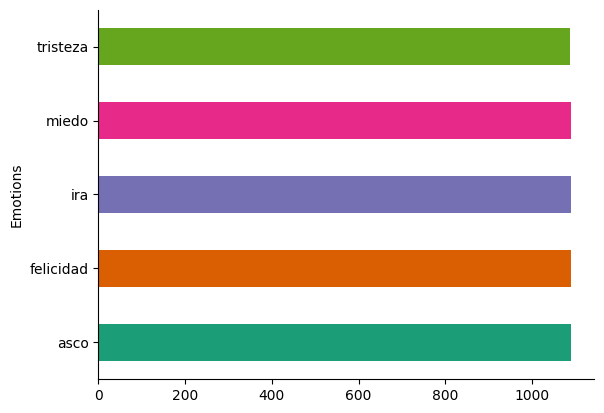

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns
Crema_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [107]:
allFeaturesCrema = FeatureExtraction(Crema_df)

In [108]:
# Preprocesamiento datos
# ==============================================================================
scaler_crema = StandardScaler()
scaler_crema.fit(allFeaturesCrema)
allFeaturesCrema_scaled = scaler_crema.transform(allFeaturesCrema) #Escalamos con ella misma

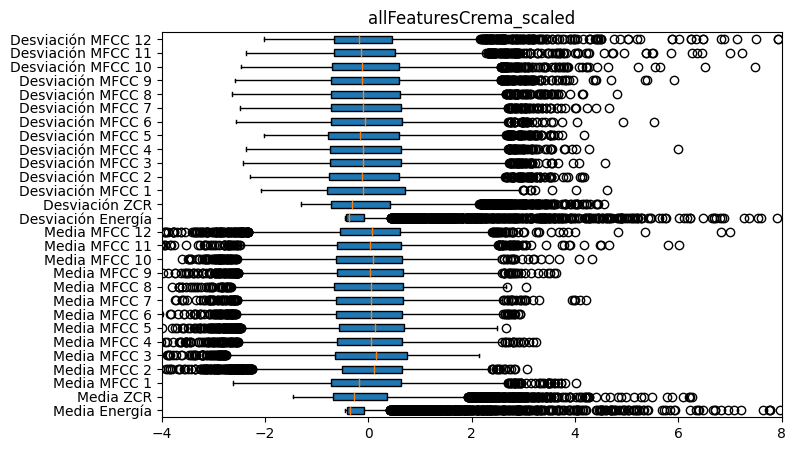

In [109]:
num_features = len(allFeaturesCrema_scaled[0])

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesCrema_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.yticks(range(1, num_features + 1), feature_names)
plt.title('allFeaturesCrema_scaled')
plt.xlim([-4,8])
# Mostrar la figura
plt.show()

In [110]:
ravel_emotion_Cr = np.ravel(emotion_Cr)
prediccionesCr_prob = modelo.predict_proba(allFeaturesCrema_scaled)
predicciones_Cr = []

for i in range(len(prediccionesCr_prob)):
  probabilidadesCr_predichas = prediccionesCr_prob[i]
  emocionCr_prediccion = np.argmax(probabilidadesCr_predichas)
  predicciones_Cr.append(mapeo_emociones[emocionCr_prediccion])

predicciones_Cr = np.array(predicciones_Cr)

In [111]:
# Accuracy
# ==============================================================================
accuracy_Cr = accuracy_score(
            y_true    = ravel_emotion_Cr,
            y_pred    = predicciones_Cr,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Cr}%")


El accuracy de test es: 32.69654665686995%


In [112]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Cr = pd.crosstab(
    ravel_emotion_Cr,
    predicciones_Cr,
    rownames=['Real'],
    colnames=['Predicción']
)


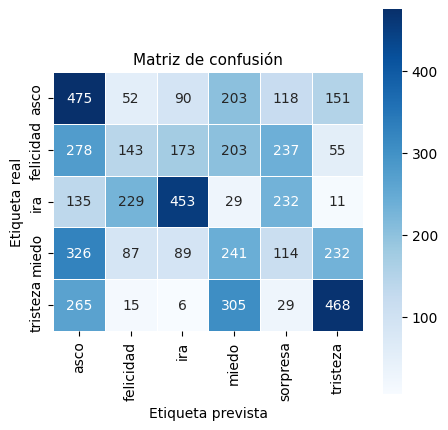

In [113]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Cr, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Cr)
plt.show()

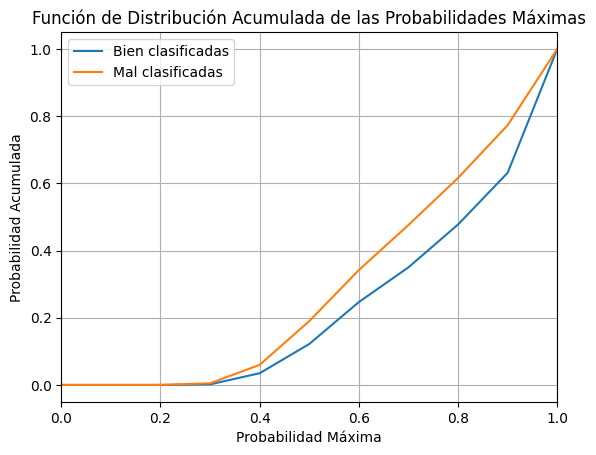

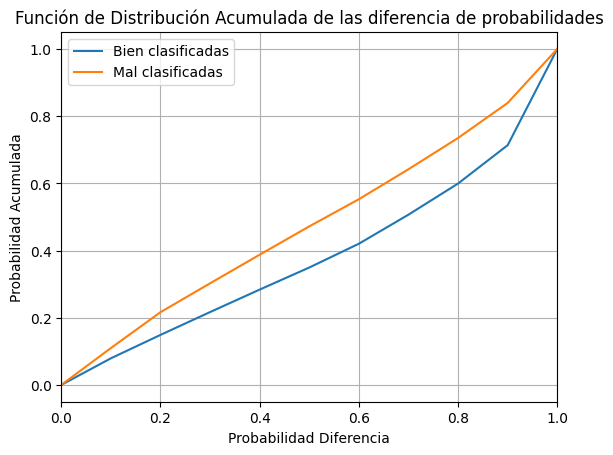

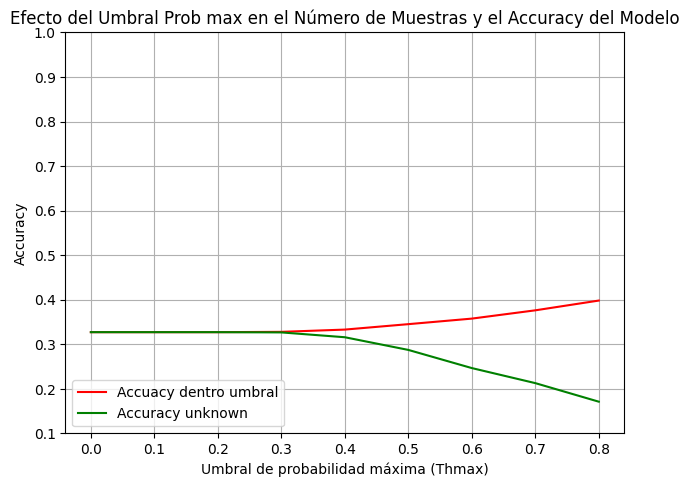

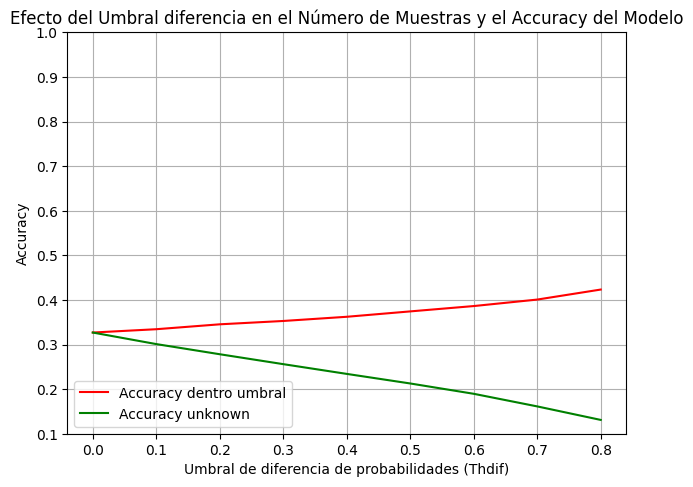

In [114]:
cdf_Probmax(prediccionesCr_prob, predicciones_Cr, ravel_emotion_Cr)
cdf_Probdif(prediccionesCr_prob, predicciones_Cr, ravel_emotion_Cr)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, Thdif_range)

In [115]:
ThMax_Cr = 0.4
ThDif_Cr = 0.0
prediccionesCr_ConUn, X_testCr_ConUn, Y_testCr_ConUn, perdidasCr_ConUn, perdidasCr_malas_ConUn = ClaseUnknown(prediccionesCr_prob,predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, ThMax_Cr, ThDif_Cr)

prediccionesCr_Ignorando, X_testCr_Ignorando, Y_testCr_Ignorando, perdidasCr_Ignorando, perdidasCr_malas_Ignorando, biendentroCr = DescartaFueraUmbral(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, ThMax_Cr, ThDif_Cr)

accuracyCr_ConUn = accuracy_score(Y_testCr_ConUn,prediccionesCr_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Cr} y Thdif={ThDif_Cr} es: {100*accuracyCr_ConUn}%, \npero se tienen {perdidasCr_ConUn} perdidas de datos bien clasificados y {perdidasCr_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyCr_Ignorando = accuracy_score(Y_testCr_Ignorando,prediccionesCr_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Cr} y Thdif={ThDif_Cr} es: {100*accuracyCr_Ignorando}%, \npero se tienen {perdidasCr_Ignorando} perdidas de datos bien clasificados y {perdidasCr_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.4 y Thdif=0.0 es: 31.557678177810434%, 
pero se tienen 62 perdidas de datos bien clasificados y 219 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.4 y Thdif=0.0 es: 33.275227580863834%, 
pero se tienen 62 perdidas de datos bien clasificados y 219 perdidas de datos mal clasificados


# RAVDESS


In [116]:
Ravdess = '/content/drive/MyDrive/TFG/RAVDESS/'

In [117]:
RavdessAudios = os.listdir(Ravdess)

file_emotion_R = []
file_path_R = []

for file in RavdessAudios:

    file_path_posible = Ravdess+file
    part=file.split('-')
    if part[2] == '01':
      continue
    elif part[2] == '02':
      continue
    elif part[2] == '03':
      if part[3] == '02':
        file_emotion_posible = 'felicidad'
      else:
        continue
    elif part[2]== '04':
      if part[3] == '02':
        file_emotion_posible = 'tristeza'
      else:
        continue
    elif part[2] == '05':
      if part[3] == '02':
        file_emotion_posible = 'ira'
      else:
        continue
    elif part[2] == '06':
      if part[3] == '02':
        file_emotion_posible = 'miedo'
      else:
        continue
    elif part[2] == '07':
      if part[3] == '02':
        file_emotion_posible = 'asco'
      else:
        continue
    elif part[2] == '08':
      if part[3] == '02':
        file_emotion_posible = 'sorpresa'
      else:
        continue
    else:
      file_emotion_posible = 'Unknown'

    file_path_R.append(file_path_posible)
    file_emotion_R.append(file_emotion_posible)


emotion_Ravdess = pd.DataFrame(file_emotion_R, columns=['Emotions'])

path_R = pd.DataFrame(file_path_R, columns=['Path'])
Ravdess_df = pd.concat([emotion_Ravdess, path_R], axis=1)
Ravdess_df

,Emotions,Path
0,tristeza,/content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
1,felicidad,/content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
2,felicidad,/content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
3,miedo,/content/drive/MyDrive/TFG/RAVDESS/03-01-06-02...
4,ira,/content/drive/MyDrive/TFG/RAVDESS/03-01-05-02...
...,...,...
571,felicidad,/content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
572,tristeza,/content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
573,tristeza,/content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
574,ira,/content/drive/MyDrive/TFG/RAVDESS/03-01-05-02...


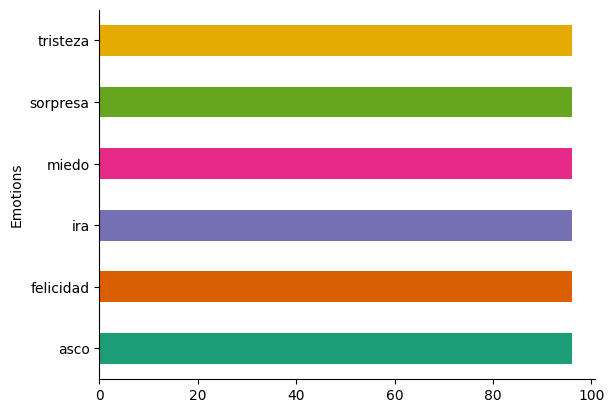

In [118]:
from matplotlib import pyplot as plt
import seaborn as sns
Ravdess_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [119]:
allFeaturesRavdess = FeatureExtraction(Ravdess_df)

In [120]:
# Preprocesamiento datos
# ==============================================================================
scaler_ravdess = StandardScaler()
scaler_ravdess.fit(allFeaturesRavdess)
allFeaturesRavdess_scaled = scaler_ravdess.transform(allFeaturesRavdess)


In [121]:
ravel_emotion_Rv = np.ravel(emotion_Ravdess)
prediccionesRv_prob = modelo.predict_proba(allFeaturesRavdess_scaled)
predicciones_Rv = []

for i in range(len(prediccionesRv_prob)):
  probabilidadesRv_predichas = prediccionesRv_prob[i]
  emocionRv_prediccion = np.argmax(probabilidadesRv_predichas)
  predicciones_Rv.append(mapeo_emociones[emocionRv_prediccion])

predicciones_Rv = np.array(predicciones_Rv)

In [122]:
# Accuracy
# ==============================================================================
accuracy_Rav = accuracy_score(
            y_true    = ravel_emotion_Rv,
            y_pred    = predicciones_Rv,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Rav}%")


El accuracy de test es: 29.34027777777778%


In [123]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Rv = pd.crosstab(
    np.ravel(ravel_emotion_Rv),
    predicciones_Rv,
    rownames=['Real'],
    colnames=['Predicción']
)

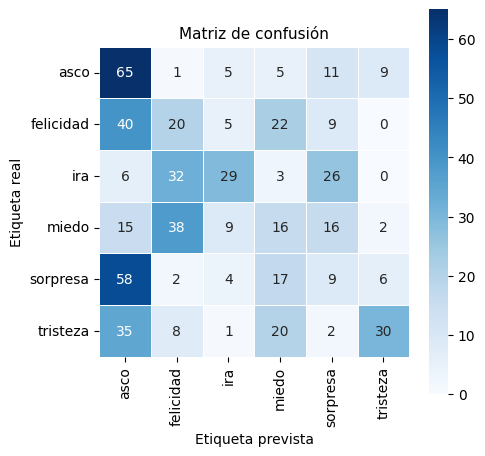

In [124]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Rv, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Rav)
plt.show()

In [125]:
mc_rv = confusion_matrix(np.ravel(ravel_emotion_Rv), predicciones_Rv)
accuracy_per_class = mc_rv.diagonal() / mc_rv.sum(axis=1)
for i, acc in enumerate(accuracy_per_class):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 67.71%
Precisión para la clase felicidad: 20.83%
Precisión para la clase ira: 30.21%
Precisión para la clase miedo: 16.67%
Precisión para la clase sorpresa: 9.38%
Precisión para la clase tristeza: 31.25%


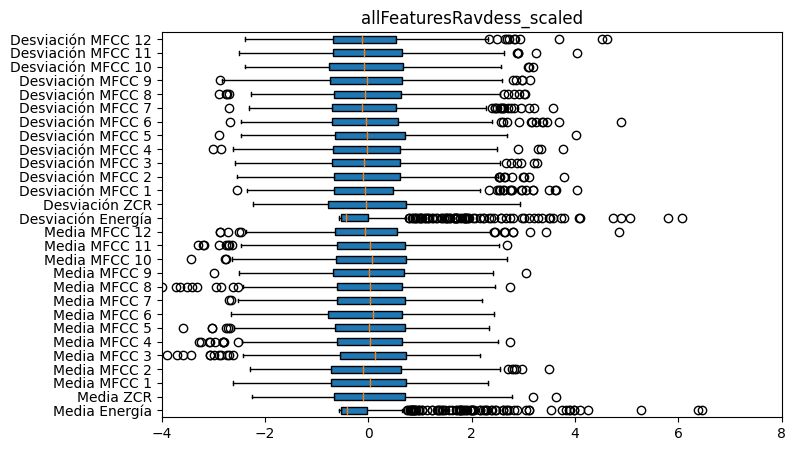

In [126]:
num_features = len(allFeaturesRavdess_scaled[0])

plt.figure(figsize=(8, 5))

plt.boxplot(allFeaturesRavdess_scaled, vert=False, patch_artist=True)


plt.yticks(range(1, num_features + 1), feature_names)
plt.title('allFeaturesRavdess_scaled')
plt.xlim([-4,8])
plt.show()

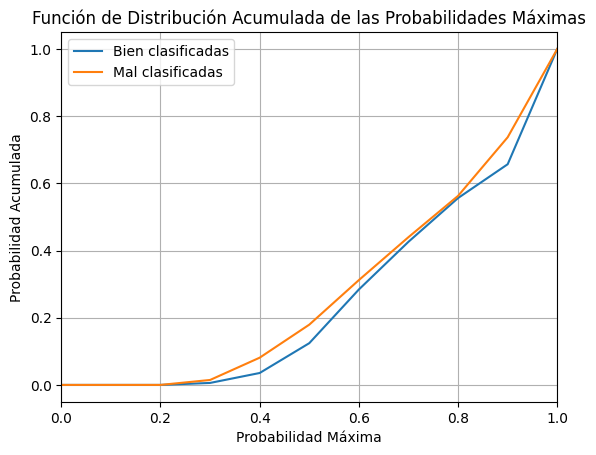

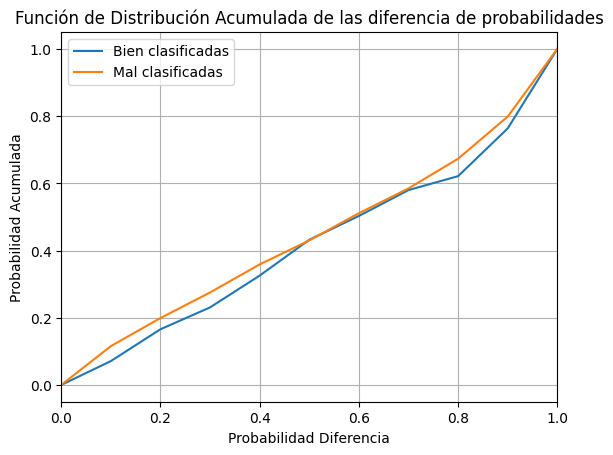

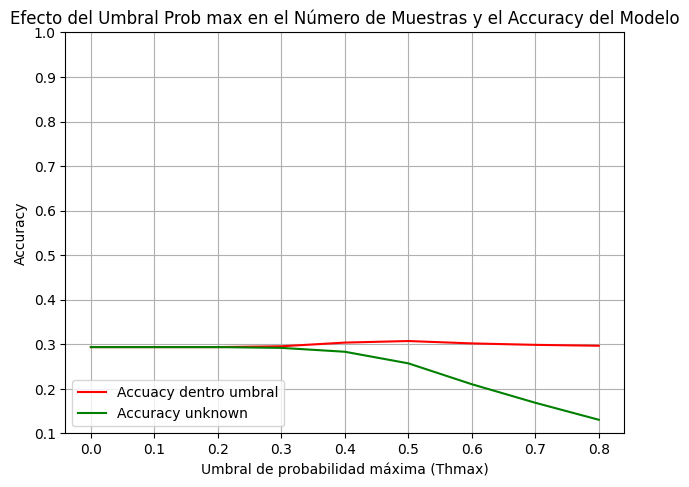

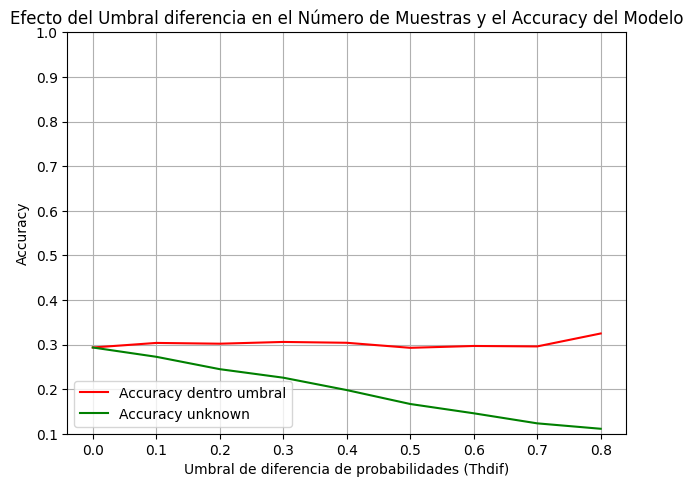

In [127]:
cdf_Probmax(prediccionesRv_prob, predicciones_Rv, ravel_emotion_Rv)
cdf_Probdif(prediccionesRv_prob, predicciones_Rv, ravel_emotion_Rv)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesRv_prob, predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesRv_prob, predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, Thdif_range)

In [128]:
ThMax_Rv = 0.3
ThDif_Rv = 0.1
prediccionesRv_ConUn, X_testRv_ConUn, Y_testRv_ConUn, perdidasRv_ConUn, perdidasRv_malas_ConUn = ClaseUnknown(prediccionesRv_prob,predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, ThMax_Rv, ThDif_Rv)

prediccionesRv_Ignorando, X_testRv_Ignorando, Y_testRv_Ignorando, perdidasRv_Ignorando, perdidasRv_malas_Ignorando, biendentroRv = DescartaFueraUmbral(prediccionesRv_prob,predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, ThMax_Rv, ThDif_Rv)

accuracyRv_ConUn = accuracy_score(Y_testRv_ConUn,prediccionesRv_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Rv} y Thdif={ThDif_Rv} es: {100*accuracyRv_ConUn}%, \npero se tienen {perdidasRv_ConUn} perdidas de datos bien clasificados y {perdidasRv_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyRv_Ignorando = accuracy_score(Y_testRv_Ignorando,prediccionesRv_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Rv} y Thdif={ThDif_Rv} es: {100*accuracyRv_Ignorando}%, \npero se tienen {perdidasRv_Ignorando} perdidas de datos bien clasificados y {perdidasRv_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.3 y Thdif=0.1 es: 27.256944444444443%, 
pero se tienen 12 perdidas de datos bien clasificados y 47 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.3 y Thdif=0.1 es: 30.36750483558994%, 
pero se tienen 12 perdidas de datos bien clasificados y 47 perdidas de datos mal clasificados


# EmoMatchSpanish

In [129]:
EmoMatchSpanish = '/content/drive/MyDrive/TFG/EmoMatchSpanish/'

In [130]:
EmoMatchSpanishAudios = os.listdir(EmoMatchSpanish)

file_emotion_Es = []
file_path_Es= []

for files in EmoMatchSpanishAudios:
    file_path_posible_Es = EmoMatchSpanish+files


    part=files.split('_')
    if part[1] == 'Asco':
      file_emotion_posible_Es = 'asco'
    elif part[1] == 'Ira':
      file_emotion_posible_Es = 'ira'
    elif part[1] == 'Miedo':
      file_emotion_posible_Es = 'miedo'
    elif part[1] == 'Alegria':
      file_emotion_posible_Es = 'felicidad'
    elif part[1] == 'Tristeza':
      file_emotion_posible_Es = 'tristeza'
    elif part[1] == 'Sorpresa':
      file_emotion_posible_Es = 'sorpresa'
    elif part[1] == 'Neutro':
      continue
    else:
      file_emotion_posible_Es = 'Unknown'

    file_path_Es.append(file_path_posible_Es)
    file_emotion_Es.append(file_emotion_posible_Es)


emotion_Es = pd.DataFrame(file_emotion_Es, columns=['Emotions'])

path_Es = pd.DataFrame(file_path_Es, columns=['Path'])
EmoMatchSpanish_df = pd.concat([emotion_Es, path_Es], axis=1)
EmoMatchSpanish_df

,Emotions,Path
0,sorpresa,/content/drive/MyDrive/TFG/EmoMatchSpanish/32_...
1,miedo,/content/drive/MyDrive/TFG/EmoMatchSpanish/41_...
2,tristeza,/content/drive/MyDrive/TFG/EmoMatchSpanish/45_...
3,sorpresa,/content/drive/MyDrive/TFG/EmoMatchSpanish/12_...
4,sorpresa,/content/drive/MyDrive/TFG/EmoMatchSpanish/31_...
...,...,...
1530,sorpresa,/content/drive/MyDrive/TFG/EmoMatchSpanish/02_...
1531,ira,/content/drive/MyDrive/TFG/EmoMatchSpanish/07_...
1532,felicidad,/content/drive/MyDrive/TFG/EmoMatchSpanish/06_...
1533,sorpresa,/content/drive/MyDrive/TFG/EmoMatchSpanish/04_...


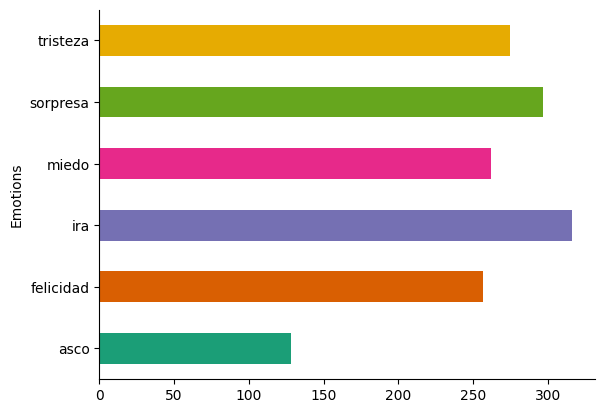

In [131]:
from matplotlib import pyplot as plt
import seaborn as sns
EmoMatchSpanish_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [132]:
allFeaturesEmoMatch = FeatureExtraction(EmoMatchSpanish_df)

In [133]:
# Preprocesamiento datos
# ==============================================================================
scaler_Es = StandardScaler()
scaler_Es.fit(allFeaturesEmoMatch)
allFeaturesEmoMatch_scaled = scaler_Es.transform(allFeaturesEmoMatch) #Escalamos con ella misma

In [134]:
ravel_emotion_Emo = np.ravel(emotion_Es)
prediccionesEmo_prob = modelo.predict_proba(allFeaturesEmoMatch_scaled)
predicciones_Emo = []

for i in range(len(prediccionesEmo_prob)):
  probabilidadesEmo_predichas = prediccionesEmo_prob[i]
  emocionEmo_prediccion = np.argmax(probabilidadesEmo_predichas)
  predicciones_Emo.append(mapeo_emociones[emocionEmo_prediccion])

predicciones_Emo = np.array(predicciones_Emo)

In [135]:
# Accuracy
# ==============================================================================
accuracy_Emo = accuracy_score(
            y_true    = emotion_Es,
            y_pred    = predicciones_Emo,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Emo}%")


El accuracy de test es: 23.452768729641694%


In [136]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Es = pd.crosstab(
    ravel_emotion_Emo,
    predicciones_Emo,
    rownames=['Real'],
    colnames=['Predicción']
)


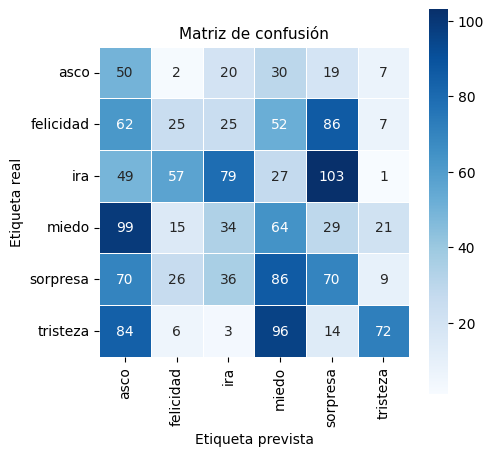

In [137]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Es, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Emo)
plt.show()

In [138]:
mc_Emo = confusion_matrix(emotion_Es, predicciones_Emo)
accuracy_per_class_emo = mc_Emo.diagonal() / mc_Emo.sum(axis=1)
for i, acc in enumerate(accuracy_per_class_emo):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 39.06%
Precisión para la clase felicidad: 9.73%
Precisión para la clase ira: 25.00%
Precisión para la clase miedo: 24.43%
Precisión para la clase sorpresa: 23.57%
Precisión para la clase tristeza: 26.18%


In [139]:
# Informe de clasificación
informe_clasificacion_emo = classification_report(emotion_Es, predicciones_Emo)
print("Informe de Clasificación:")
print(informe_clasificacion_emo)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.12      0.39      0.18       128
   felicidad       0.19      0.10      0.13       257
         ira       0.40      0.25      0.31       316
       miedo       0.18      0.24      0.21       262
    sorpresa       0.22      0.24      0.23       297
    tristeza       0.62      0.26      0.37       275

    accuracy                           0.23      1535
   macro avg       0.29      0.25      0.24      1535
weighted avg       0.31      0.23      0.25      1535



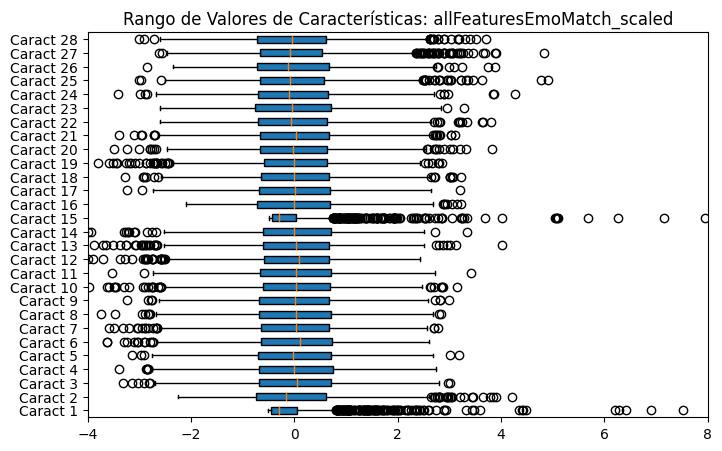

In [140]:
num_features = len(allFeaturesEmoMatch_scaled[0])

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesEmoMatch_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características: allFeaturesEmoMatch_scaled')
plt.xlim([-4,8])
# Mostrar la figura
plt.show()

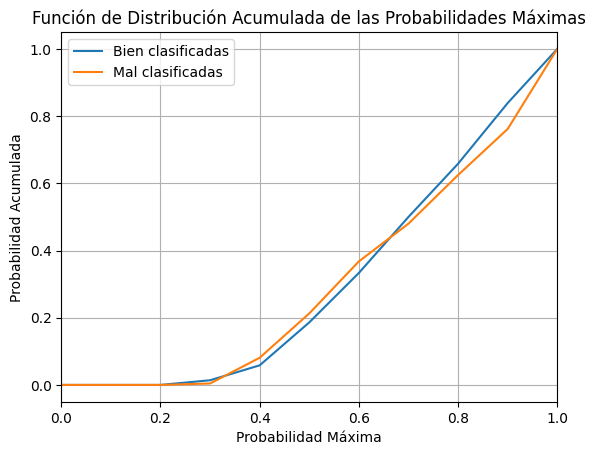

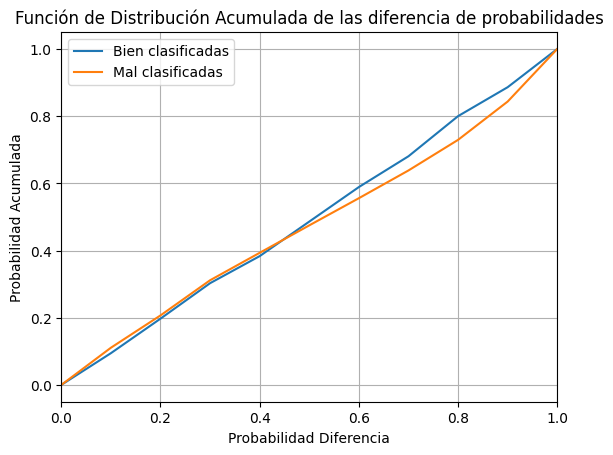

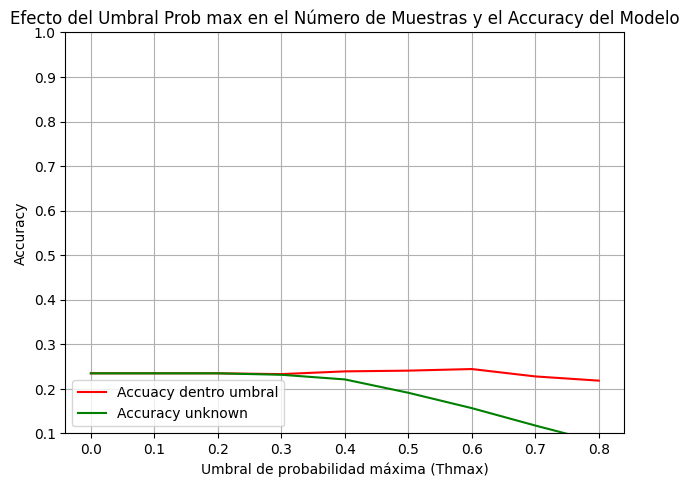

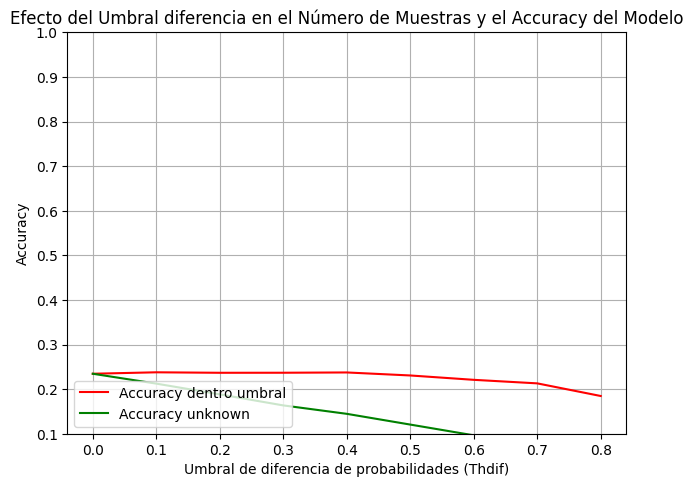

In [141]:
cdf_Probmax(prediccionesEmo_prob, predicciones_Emo, ravel_emotion_Emo)
cdf_Probdif(prediccionesEmo_prob, predicciones_Emo, ravel_emotion_Emo)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesEmo_prob, predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesEmo_prob, predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, Thdif_range)

In [142]:
ThMax_Emo = 0.4
ThDif_Emo = 0.0
prediccionesEmo_ConUn, X_testEmo_ConUn, Y_testEmo_ConUn, perdidasEmo_ConUn, perdidasEmo_malas_ConUn = ClaseUnknown(prediccionesEmo_prob,predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, ThMax_Emo, ThDif_Emo)

prediccionesEmo_Ignorando, X_testEmo_Ignorando, Y_testEmo_Ignorando, perdidasEmo_Ignorando, perdidasEmo_malas_Ignorando, biendentroEmo = DescartaFueraUmbral(prediccionesEmo_prob,predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, ThMax_Emo, ThDif_Emo)


accuracyEmo_ConUn = accuracy_score(Y_testEmo_ConUn,prediccionesEmo_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Emo} y Thdif={ThDif_Emo} es: {100*accuracyEmo_ConUn}%, \npero se tienen {perdidasEmo_ConUn} perdidas de datos bien clasificados y {perdidasEmo_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyEmo_Ignorando = accuracy_score(Y_testEmo_Ignorando,prediccionesEmo_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Emo} y Thdif={ThDif_Emo} es: {100*accuracyEmo_Ignorando}%, \npero se tienen {perdidasEmo_Ignorando} perdidas de datos bien clasificados y {perdidasEmo_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.4 y Thdif=0.0 es: 22.08469055374593%, 
pero se tienen 21 perdidas de datos bien clasificados y 95 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.4 y Thdif=0.0 es: 23.890063424947147%, 
pero se tienen 21 perdidas de datos bien clasificados y 95 perdidas de datos mal clasificados
